<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/transform_to_week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create Flights Dataset

The goal of this code is to create an array of shape (weeks, hours, 100, 100, 20) for training the model later.

In [2]:
import glob

# Home folder
%cd /content/drive/MyDrive/opportunistic-utm

# List of folders with data
folder_list = []
for folder in glob.iglob('dataset/**/**/', recursive=False):
  folder_list.append(folder)

folder_list[:5]

/content/drive/MyDrive/opportunistic-utm


['dataset/2019-01/2019-01-01/',
 'dataset/2019-01/2019-01-02/',
 'dataset/2019-01/2019-01-03/',
 'dataset/2019-01/2019-01-04/',
 'dataset/2019-01/2019-01-05/']

In [3]:
import datetime
import numpy as np
import os

# Gets date from each folder and appends each Monday of a date to a list
# The goal is to get the number of weeks present in the list
monday_list = []
for folder in folder_list:
  folder_date = os.path.basename(os.path.normpath(folder))
  date = datetime.datetime.strptime(folder_date, '%Y-%m-%d')
  monday_date = date - datetime.timedelta(days=date.weekday())
  monday_list.append(monday_date)

# Filters the list by unique monday values and complete weeks of 7 days
monday_list = np.unique(np.array(monday_list), return_counts=True)
filter = np.where(monday_list[1] == 7, True, False)
monday_list = monday_list[0][filter].tolist()

In [4]:
from tqdm import tqdm

# Data array is created by looping each Monday through 7 days of the week
index = 0
week_array = []

# Iterates through Monday list
for monday in tqdm(monday_list[0:2]):
  hours_array = np.empty((1,100,100,20))
  
  # Iterates over 7 days of that Monday week
  for day in range(7):
    day_date = monday + datetime.timedelta(days=day)
    day_str = day_date.strftime('%Y-%m-%d')
    month_str = day_date.strftime('%Y-%m')
    files = np.sort(glob.glob(f'dataset/{month_str}/{day_str}/*.npy', recursive=False))
    
    # Iterates over 24 hours of every day
    for i in range(0, 24):
      next_hour = np.expand_dims(np.moveaxis(np.load(files[i]), 0, -1), 0)
      hours_array = np.concatenate((hours_array, next_hour), axis=0)
  week_array.append(hours_array[1:])

# Transforms to Numpy array
week_array = np.array(week_array)
week_array.shape

100%|██████████| 2/2 [01:35<00:00, 47.61s/it]


(2, 168, 100, 100, 20)

# Visualization

In [5]:
# Flattens multichannel array
def flatten_array(input_array):
  len_array = input_array.shape[-1]
  levels_array = []
  for i in range(0, len_array):
    level = input_array[:, :, i]*((i+1)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)

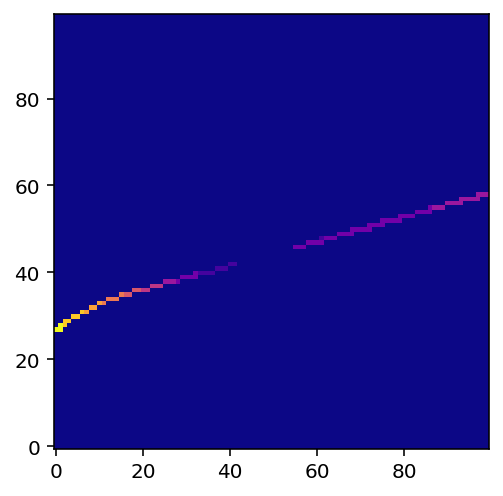

In [6]:
# Previews single image
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

flatten = flatten_array(week_array[0,0])
plt.imshow(flatten, origin='lower', cmap = plt.get_cmap('plasma'))

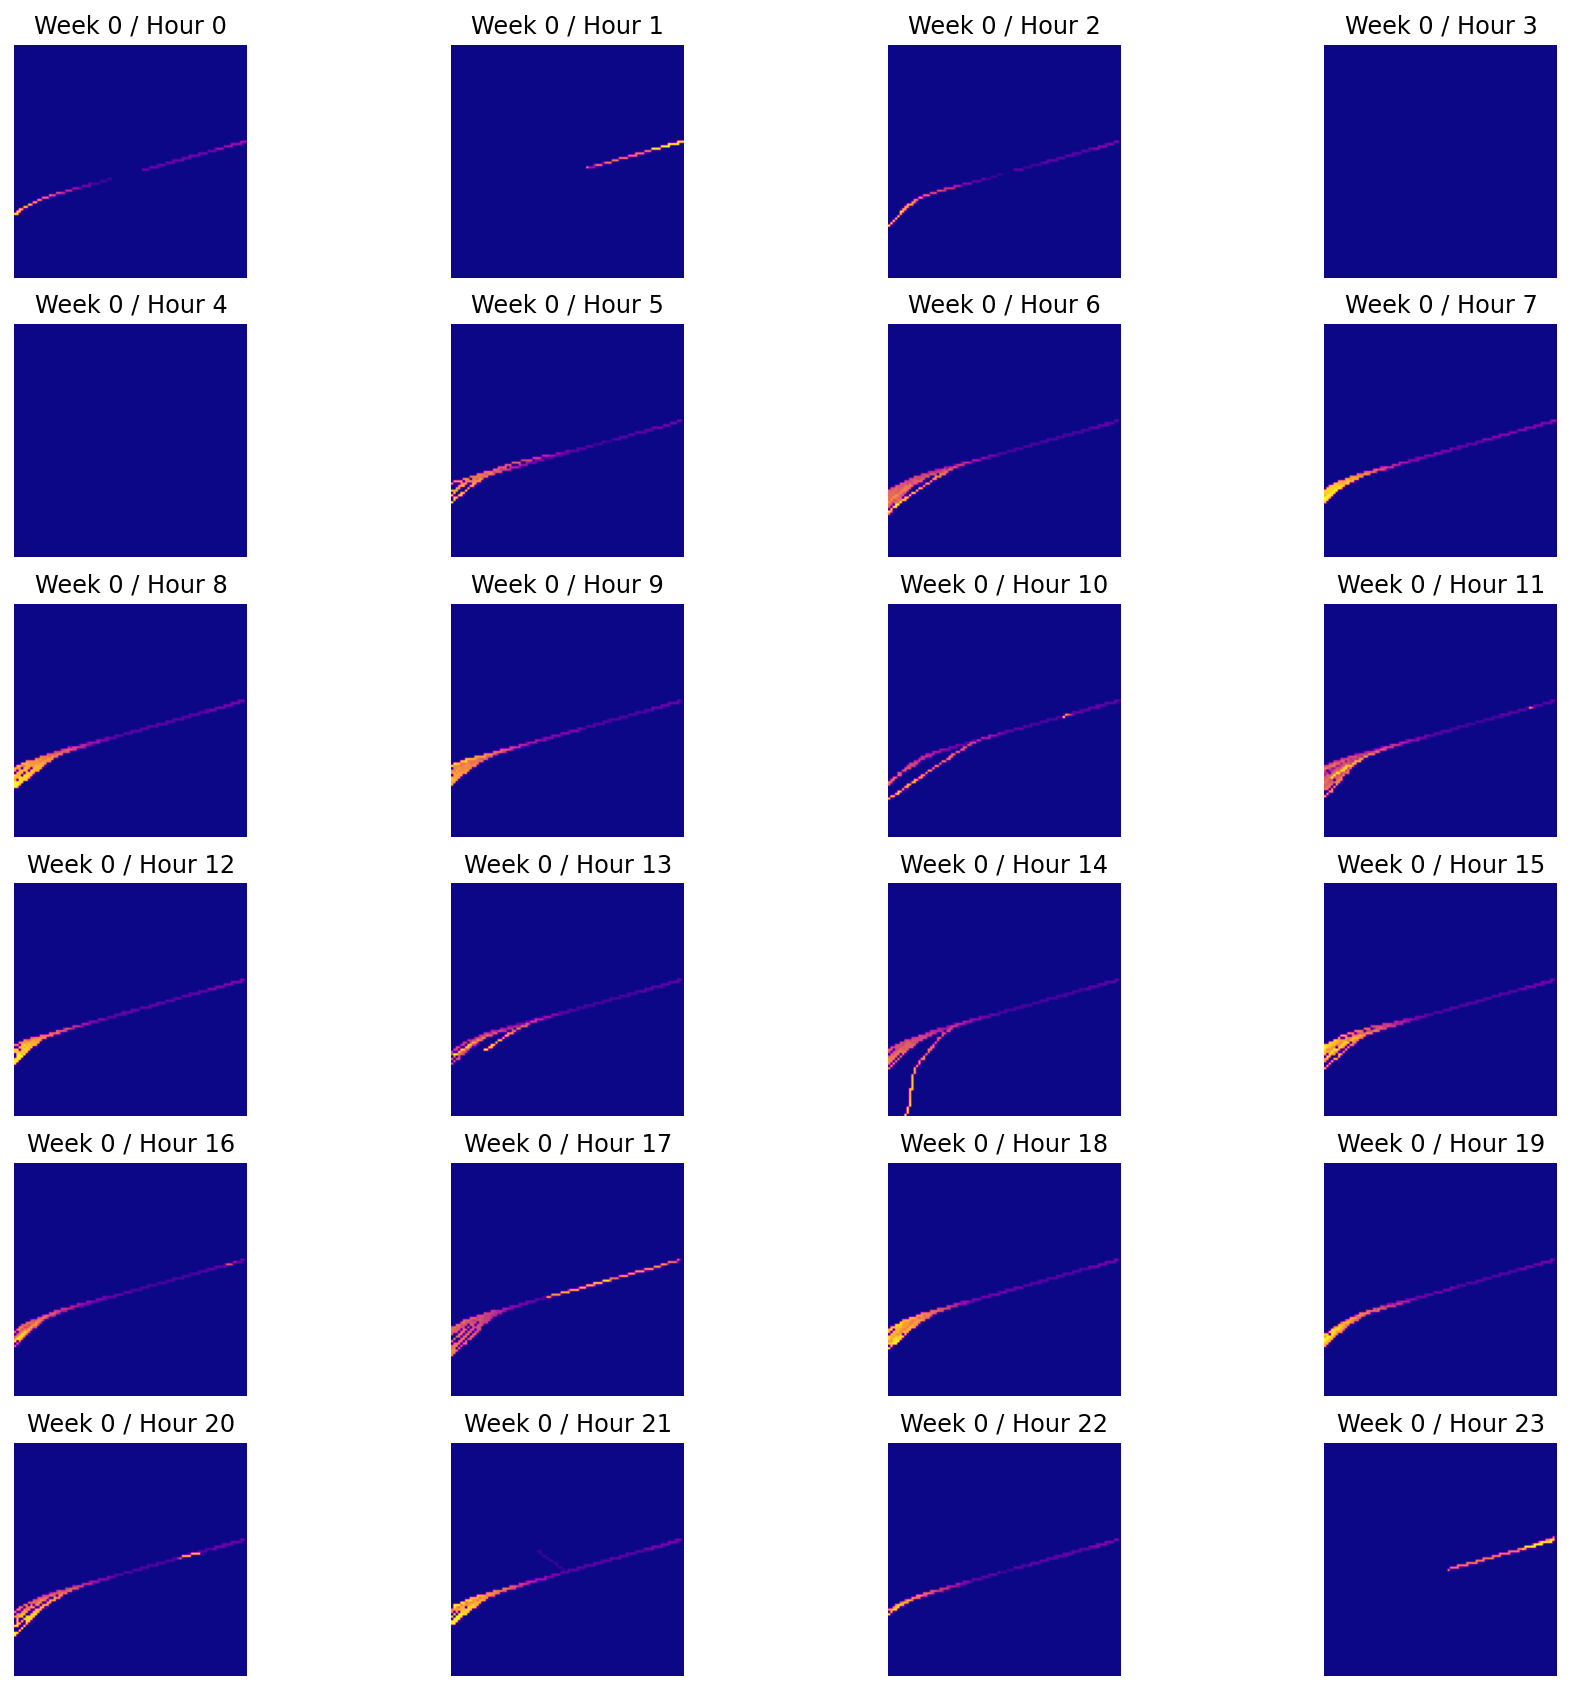

In [16]:
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

week = 0 # Week since dataset started
day = 0 # 0 to 6 / Mon to Sun

# Previews a whole day
fig, ax = plt.subplots(6, 4, figsize=(15, 15))
for idx, ax in enumerate(ax.flat):
  plot = ax.imshow(flatten_array(week_array[week, idx + (day * 24)]), origin='lower', cmap = plt.get_cmap('plasma'))
  # plot.set_clim(vmin=0, vmax=max_plot_value)
  ax.set_title(f'Week {week} / Hour {idx + (day * 24)}')
  ax.axis("off")

# Calculate Envelope

100%|██████████| 20/20 [00:00<00:00, 29.87it/s]

Level 0: 469
Level 1: 400
Level 2: 327
Level 3: 531
Level 4: 450
Level 5: 626
Level 6: 579
Level 7: 491
Level 8: 594
Level 9: 473
Level 10: 455
Level 11: 441
Level 12: 425
Level 13: 323
Level 14: 311
Level 15: 225
Level 16: 121
Level 17: 0
Level 18: 0
Level 19: 0


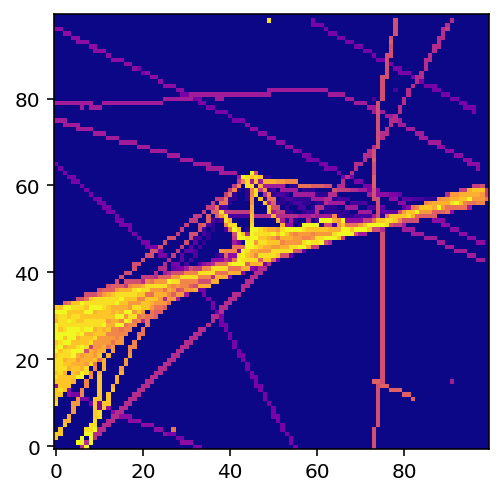

In [22]:
from tqdm import tqdm
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Flights average
flights_average = np.zeros([100,100,20]) 
for channel in tqdm(range(20)): # iterate channels
  for week in range(week_array.shape[0]): # iterate weeks
    flights_average[:, :, channel] += np.sum(week_array[week, :, :, :, channel], axis=0)

flights_average /= (week_array.shape[0] * week_array.shape[1]) # total_weeks x total_hours
flights_average = np.where(flights_average > 0, 1, 0)

for i in range(0, flights_average.shape[-1]):
  print(f'Level {i}: {np.sum(flights_average[:,:,i])}')

flatten_average = flatten_array(flights_average)
plt.imshow(flatten_average, origin='lower', cmap = plt.get_cmap('plasma'))